# Varredura em $\epsilon:\bar{\sigma}(\epsilon), |\langle M\rangle|(\epsilon), p(t)$ e checagem com fronteiras teóricas

1) $\bar{\sigma}(\epsilon)+$ pontos do mapa teórico
2) Curva de persistência p(t) para $\epsilon$ representativos
3) Parâmetro de ordem $|\langle M\rangle|(\epsilon)$  + comparação qualitativa com o paper

## Imports & Setup

In [1]:
import os, sys
# garante que o pacote local seja enxergado (repo/notebooks -> adicionar o diretório pai)
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np, math, json
import matplotlib.pyplot as plt
from pathlib import Path

from gcm.core import Config, GloballyCoupledMaps
from gcm.maps import sync_boundaries, escape_boundaries, bistable_intervals
from gcm.metrics import spins, persistence_curve, magnetization, order_param_M

FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(parents=True, exist_ok=True); DATA.mkdir(parents=True, exist_ok=True)

def estimate_lambda_local(x_series, mu):
    """λ_est ≈ mean_t ln|f'(x_t)| (tempo finito). Para este mapa, ~ ln|μ|."""
    fp = fprime_piecewise(x_series, mu)
    return float(np.mean(np.log(np.abs(fp))))



def lambdas(mu, eps, x_series_for_lambda):
    """Retorna (λ_teo, λ_est, λ_perp) para exibir/checar."""
    lam_teo = math.log(abs(mu))                         # λ = ln|μ|
    lam_est = estimate_lambda_local(x_series_for_lambda, mu)
    lam_perp = math.log(abs(1.0 - eps)) + lam_teo      # λ⊥ = ln|1-ε| + λ
    return lam_teo, lam_est, lam_perp


def run_with_ic(mu, eps, N=512, init="half_half", T_burn=600, T_meas=600, seed=0):
    """Roda com um init padrão do core; retorna (traj, sys)."""
    cfg = Config(N=N, eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.reset(init=init)
    traj = sys.run(T_meas, track=True)
    return traj, sys


# Paleta de regiões (mesma dos notebooks anteriores)
COL_NON_SYNC  = "#e09f3e"  # não sincronizado (Honey Bronze)
COL_SYNC_STAT = "#335c67"  # síncrono estacionário (Dark Slate Grey)
COL_SYNC_CHAOS= "#9fd356"  # síncrono caótico (Yellow Green)
COL_ESCAPE    = "#9e2a2b"  # escape (Brown Red)

# Paleta dos 3 traços solicitados (M, sigma, p∞):
COL_CURVE_M     = "#7e57c2"  # roxo (M)
COL_CURVE_SIGMA = "#e09f3e"  # laranja (σ)
COL_CURVE_P     = "#2e7d32"  # verde (p∞)

MU = 1.9           # foco do artigo
N  = 10000
T_BURN = 1500
T_MEAS = 1500
TOL_SYNC = 1e-7


## Parte A -- Varredura em $\varepsilon \in [0,2]$ dos observáveis em $\mu=1.9$

In [2]:
# Malha de ε
EPS_GRID = np.linspace(0.0, 2.0, 42) # passo

p_infty = []
sigma_bar = []
M_bar = []
escaped_frac = []

for i, eps in enumerate(EPS_GRID):
    # roda sistema (IC half_half como padrão do projeto)
    traj, sys = run_with_ic(mu=MU, eps=eps, N=N, init="half_half",
                            T_burn=T_BURN, T_meas=T_MEAS, seed=1000+i)

    # σ̄: média temporal do desvio-padrão entre os N mapas
    sigmas = np.std(traj, axis=1)
    sigma_bar.append(float(np.mean(sigmas)))

    # |<M>|: média temporal do módulo de M_t
    Ms = np.apply_along_axis(lambda x: magnetization(x), 1, traj)
    M_bar.append(float(order_param_M(Ms)))

    # p_infty: último valor da curva de persistência
    S = spins(traj)           # (T_meas, N) em {-1, +1}
    p_t = persistence_curve(S)
    p_infty.append(float(p_t[-1]))

    # escaped (fração fora de [-1,1] ao final)
    escaped_frac.append(float(np.mean(np.abs(sys.x) > 1.0)))

p_infty  = np.array(p_infty)
sigma_bar= np.array(sigma_bar)
M_bar    = np.array(M_bar)
escaped_frac = np.array(escaped_frac)

# Guarda CSV/JSON
np.savetxt(DATA/"eps_scan_mu1.9.csv",
           np.c_[EPS_GRID, p_infty, sigma_bar, M_bar, escaped_frac],
           delimiter=",", header="eps,p_infty,sigma_bar,M_bar,escaped_frac", comments="", fmt="%.8g")
(DATA/"eps_scan_mu1.9.json").write_text(
    json.dumps({"eps": EPS_GRID.tolist(),
                "p_infty": p_infty.tolist(),
                "sigma_bar": sigma_bar.tolist(),
                "M_bar": M_bar.tolist(),
                "escaped_frac": escaped_frac.tolist()}, indent=2),
    encoding="utf-8")


3812

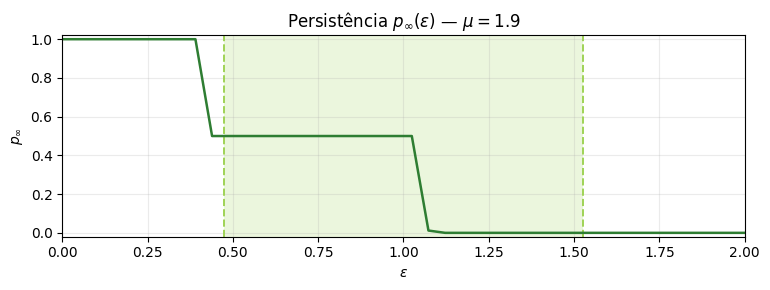

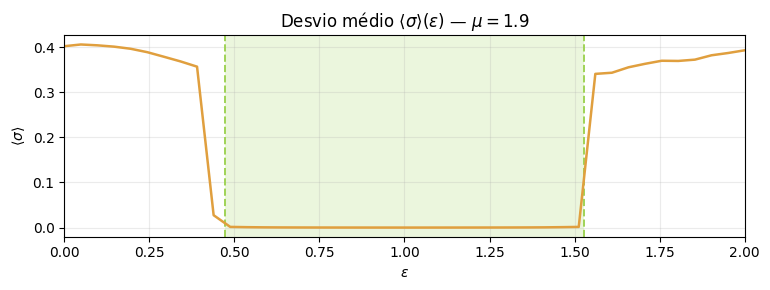

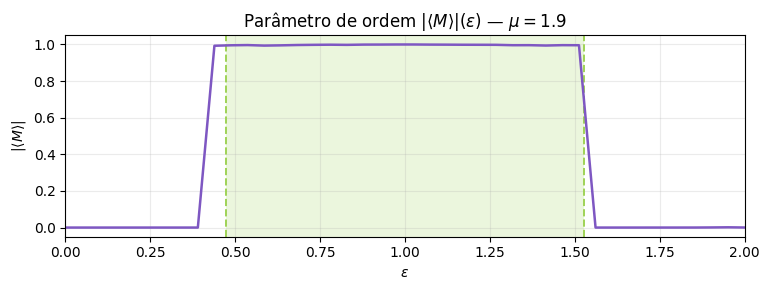

In [3]:
# Fronteiras teóricas para MU=1.9
eps_sync_inf, eps_sync_sup = sync_boundaries(MU)  # ~ 0.473, 1.526
esc_lo, esc_hi             = escape_boundaries(MU) # ~ -0.579, 2.579 (não pega escape no eixo até 2)

def shade_sync_band(ax, mu, color, alpha=0.12):
    a, b = sync_boundaries(mu)
    ax.axvspan(max(0,a), min(2,b), color=color, alpha=alpha, linewidth=0)

# p∞(ε)
fig, ax = plt.subplots(figsize=(7.8, 3.0))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, 0.20)
ax.axvline(eps_sync_inf, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.axvline(eps_sync_sup, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.plot(EPS_GRID, p_infty, lw=1.8, color=COL_CURVE_P)
ax.set_xlim(0, 2); ax.set_ylim(-0.02, 1.02)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$p_\infty$")
ax.set_title(rf"Persistência $p_\infty(\varepsilon)$ — $\mu={MU}$")
ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"02_pinf_vs_eps_mu1.9.png", dpi=200); plt.show()

# σ̄(ε)
fig, ax = plt.subplots(figsize=(7.8, 3.0))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, 0.20)
ax.axvline(eps_sync_inf, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.axvline(eps_sync_sup, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.plot(EPS_GRID, sigma_bar, lw=1.8, color=COL_CURVE_SIGMA)
ax.set_xlim(0, 2)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$\langle \sigma \rangle$")
ax.set_title(rf"Desvio médio $\langle \sigma \rangle(\varepsilon)$ — $\mu={MU}$")
ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"02_sigma_bar_vs_eps_mu1.9.png", dpi=200); plt.show()

# |<M>|(ε)
fig, ax = plt.subplots(figsize=(7.8, 3.0))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, 0.20)
ax.axvline(eps_sync_inf, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.axvline(eps_sync_sup, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.plot(EPS_GRID, M_bar, lw=1.8, color=COL_CURVE_M)
ax.set_xlim(0, 2)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$|\langle M \rangle|$")
ax.set_title(rf"Parâmetro de ordem $|\langle M \rangle|(\varepsilon)$ — $\mu={MU}$")
ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"02_Mbar_vs_eps_mu1.9.png", dpi=200); plt.show()

**Discussão sobre o gráfico**

Lembrando que essa varredura em $\varepsilon$ está fixada em $\mu=1.9$. 

O que observamos olhando o gráfico é que há 3 situações diferentes conforme variamos $\varepsilon$ com $|M|= 1$ (estado ordenado). 

* (i): Um estado **ordenado** e **dessincronizado** com $\sigma >0$  e $p_\infty = 0.5$.
* (ii): Um estado **ordenado** e **sincronizado** com $\sigma =0$ e $p_\infty = 0.5$.
* (iii): Um estado **ordenado** e **sincronizado** com $\sigma =0$ e $p_\infty = 0.0$.

O que isso significa? No primeiro caso é o que já vimso e entendemos, o sistema ainda não atingiu a sincronia, mas a maioria dos mapas já se concentra em dos lados (positivo ou negativo) de $x$. Isso está refletido em $p_\infty$, note que metade dos mapas trocaram seu valor ao longo do tempo nessa região.

Já para (ii), temos o caso mais intuitivo de todos, o sistema se encontra ordenado e sincronizado, para isso aproximadamente metade dos spins precisou trocar de lado.

Por fim, o caso mais estranho parece ser o (iii). O sistema se encontra ordenado e sincronizado, entretanto todos os spins trocaram de sinal ao menos uma vez ao longo do tempo, indicando por $p_infty=0$. Isso acontece pois $(1-\varepsilon)$ torna-se negativo e todos são jogados para o lado contrário de seus sinais iniciais. Estamos novamente em uma região turbulenta, mas podemos interpretar que a força global faz todos mudarem de lado sem se estabilizar. No caso de $\varepsilon$ pequeno o que encontramos é uma situação contrária a força global não é suficiente para nada, ou seja, todos ficam próximo de seus sinais iniciais, sem sincronizar. Isso quer dizer que se a manchete nacional for extremamente influente o impacto é na verdade negativo. Todos trocam de opinião o tempo todo e ninguém estabiliza na mesma rota/canal.

## Parte B) Pontos simulados no plato ($\mu$, $\varepsilon$) e comparação com fronteiras teóricas

Podemos simular pontos teóricos na grade de $\mu$, $\varepsilon$ e averiguar se eles de fatam estão de acordo com as expectativas teóricas seguindo os critérios:

> * **Sincrono caótico x Não síncrono:** pelo $\langle \sigma \rangle$ para t grande.
> * **Síncrono estacionário:** Além de $\sigma$ ser próximo de 0 a média de $x$ deve ser 0.
> * **Escape:** |x| ficou maior que 1.

In [4]:
# Grade moderada para ser rápida no Colab
MU_LIST = np.array([-2.5, -1.6, -0.8, -0.5, 0.5, 0.8, 1.1, 1.9, 2.5])
EPS_LIST = np.linspace(0.0, 2.0, 11)  # 0, 0.2, ..., 2.0

N_pts   = 400      # menor N para essa varredura 2D
T_BURN2 = 1000
T_MEAS2 = 1000
TOL_SIG = 1e-3      # critério de sincronização pelo σ médio
TOL_X0  = 1e-2       # critério "x→0" (média de |x| final pequena) para estacionário

pts_mu, pts_eps = [], []
pts_label = []   # "sync_stat", "sync_chaos", "nonsync", "escape"

def classify_point(mu, eps, N=N_pts, T_burn=T_BURN2, T_meas=T_MEAS2, seed=0):
    traj, sys = run_with_ic(mu=mu, eps=eps, N=N, init="uniform",
                            T_burn=T_burn, T_meas=T_meas, seed=seed)
    # escape?
    if np.any(np.abs(sys.x) > 1.0):
        return "escape"

    # σ médio
    sigmas = np.std(traj, axis=1)
    sig_mean = float(np.mean(sigmas))
    if sig_mean < TOL_SIG:
        # sincronizado — estacionário se x→0
        x_final = np.mean(np.abs(sys.x))
        if x_final < TOL_X0:
            return "sync_stat"
        else:
            return "sync_chaos"
    else:
        return "nonsync"

# constrói a nuvem de pontos
for i, mu0 in enumerate(MU_LIST):
    for j, eps0 in enumerate(EPS_LIST):
        lab = classify_point(mu0, eps0, seed=10000 + 100*i + j)
        pts_mu.append(mu0); pts_eps.append(eps0); pts_label.append(lab)

pts_mu = np.array(pts_mu); pts_eps = np.array(pts_eps); pts_label = np.array(pts_label)

# Salva para eventual reuso/plots adicionais
(DATA/"mu_eps_points_classified.json").write_text(
    json.dumps({"mu": pts_mu.tolist(), "eps": pts_eps.tolist(), "label": pts_label.tolist()}, indent=2),
    encoding="utf-8")


C:\Users\Igora\PycharmProjects\Projeto_Final_Python_na_Fisica\gcm\maps.py:87: RuntimeWarning: overflow encountered in multiply
  y[m_right] = 2.0 * mu / 3.0 - mu * x[m_right]
C:\Users\Igora\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Igora\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Igora\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Igora\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:204: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where

3921

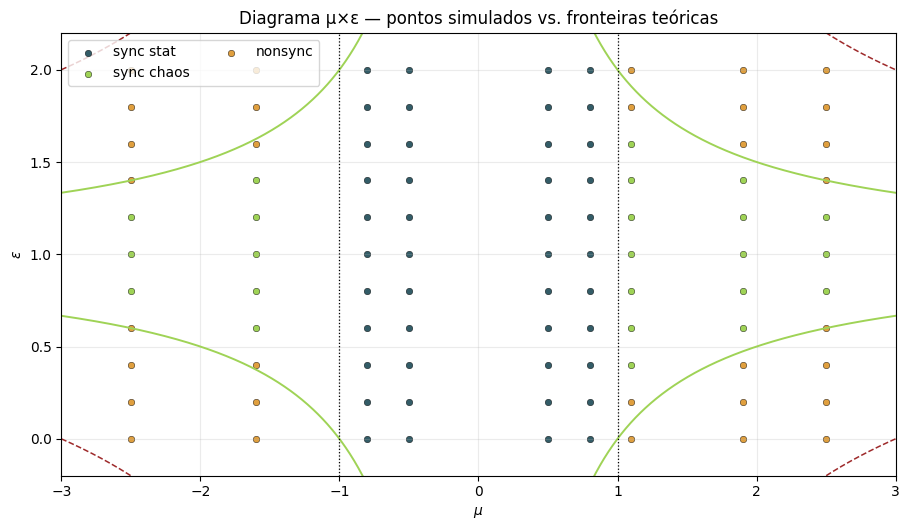

In [5]:
# Curvas teóricas no plano μ×ε
MU_GRID = np.linspace(-3.0, 3.0, 1201)
sync_lo = np.empty_like(MU_GRID); sync_hi = np.empty_like(MU_GRID)
esc_lo  = np.empty_like(MU_GRID); esc_hi  = np.empty_like(MU_GRID)
for k, mu0 in enumerate(MU_GRID):
    if abs(mu0) < 1e-12:
        sync_lo[k] = np.nan; sync_hi[k] = np.nan
        esc_lo[k]  = np.nan; esc_hi[k]  = np.nan
    else:
        a, b = sync_boundaries(mu0)
        el, eh = escape_boundaries(mu0)
        sync_lo[k], sync_hi[k] = a, b
        esc_lo[k],  esc_hi[k]  = el, eh

fig, ax = plt.subplots(figsize=(9.2, 5.4))

# Sombreamento (leve) das regiões teóricas para referência
#ax.fill_between(MU_GRID, sync_lo, sync_hi, color=COL_SYNC_CHAOS, alpha=0.18, linewidth=0)        # banda de sincronização
ax.plot(MU_GRID, sync_lo, color=COL_SYNC_CHAOS, lw=1.4)  # bordas da banda
ax.plot(MU_GRID, sync_hi, color=COL_SYNC_CHAOS, lw=1.4)

# Escape (tracejado)
ax.plot(MU_GRID, esc_lo, color=COL_ESCAPE, lw=1.1, ls="--")
ax.plot(MU_GRID, esc_hi, color=COL_ESCAPE, lw=1.1, ls="--")

# Verticais μ=±1 (apenas referencia visual)
ax.axvline(-1.0, color="k", lw=0.9, ls=":")
ax.axvline( 1.0, color="k", lw=0.9, ls=":")

# Espalhamento de pontos simulados, com cor por classe
def color_for(lbl):
    return {
        "sync_stat":  COL_SYNC_STAT,
        "sync_chaos": COL_SYNC_CHAOS,
        "nonsync":    COL_NON_SYNC,
        "escape":     COL_ESCAPE
    }[lbl]

for lbl in ["sync_stat","sync_chaos","nonsync","escape"]:
    m = (pts_label == lbl)
    if np.any(m):
        ax.scatter(pts_mu[m], pts_eps[m], s=22, c=color_for(lbl),
                   edgecolors="k", linewidths=0.3, label=lbl.replace("_", " "))

ax.set_xlim(-3, 3); ax.set_ylim(-0.2, 2.2)
ax.set_xlabel(r"$\mu$"); ax.set_ylabel(r"$\varepsilon$")
ax.set_title("Diagrama μ×ε — pontos simulados vs. fronteiras teóricas")
ax.grid(alpha=0.25); ax.legend(loc="upper left", ncol=2, frameon=True)

fig.tight_layout(); fig.savefig(FIGS/"02_mu_eps_points_vs_theory.png", dpi=220); plt.show()

A imagem acima demonstra a compatibilidade entre os pontos simulados e a teoria é claro que quanto maior o valor de N e de passos temos uma precisão maior nesse intervalo.

Esse gráfico serve apenas para observar que de fato há uma boa correspondência, mesmo para N pequeno e um número de passos não muito grande, entre a teoria e os pontos simulados, mostrando como tudo está de acordo e se encaixa.

## E adiante? 

Com isso fechamos tudo que é abordado no artigo, no grosso, mas o que exatamente isso tem a ver com **transições de fase de primeira ordem** e minha área de pesquisa (Ondas gravatcionais geradas por essas transições ).

Para entendermos isso melhor, temos que interpretar como variar $\varepsilon$ está ligado a uma transição de fase de primeira ordem e faremos isso no próximo notebook.